# $$\text{WEATHER - BOSTON}$$
### $$\textbf{Analiza danych rzeczywistych przy pomocy modelu ARMA}$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.optimize import curve_fit
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller, acovf
import statsmodels.api as sm

C:\Users\Magdalena\AppData\Local\Temp\ipykernel_11632\3188263255.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
from scipy.stats import ttest_1samp, levene, shapiro, jarque_bera, norm
from statsmodels.stats.diagnostic import het_arch, acorr_ljungbox

## 1. Wstęp

    1.1. Czy w analizowanych danych występują braki?

In [3]:
# BOSTON
data = pd.read_csv('boston.csv')
data['time'] = pd.to_datetime(data['time'])
data.isnull().sum()

time      0
tavg      1
tmin      0
tmax      0
prcp      0
wdir    587
wspd      0
pres    161
dtype: int64

- uzupełnienie braków - średnia temperatura z dnia poprzedniego i dnia następnego

In [4]:
data['tavg'] = data['tavg'].replace('', np.nan)
missing_index = data[data['tavg'].isnull()].index[0]

data.head(missing_index+1)

,time,tavg,tmin,tmax,prcp,wdir,wspd,pres
0,2013-03-01,3.2,1.1,5.0,0.0,342.0,15.1,1002.7
1,2013-03-02,3.1,1.1,5.6,0.0,307.0,14.4,1004.2
2,2013-03-03,2.6,0.6,6.1,0.0,NaN,14.4,1002.6
3,2013-03-04,1.8,-0.6,5.0,0.0,303.0,28.1,1003.0
4,2013-03-05,2.9,0.0,6.1,0.0,NaN,16.6,1013.5
5,2013-03-06,3.2,1.7,5.0,1.3,58.0,36.7,1018.5
6,2013-03-07,0.4,-1.1,2.8,11.7,20.0,38.2,1016.5
7,2013-03-08,0.4,-2.2,5.6,23.9,9.0,29.5,1016.3
8,2013-03-09,1.8,-0.6,3.3,0.0,35.0,17.6,1024.3
9,2013-03-10,NaN,-2.2,2.8,0.0,NaN,12.6,NaN


In [5]:
prev_day = data['tavg'].iloc[missing_index - 1]
next_day = data['tavg'].iloc[missing_index + 1]
data.at[missing_index, 'tavg'] = (prev_day + next_day) / 2

data.head(missing_index+1)

,time,tavg,tmin,tmax,prcp,wdir,wspd,pres
0,2013-03-01,3.2,1.1,5.0,0.0,342.0,15.1,1002.7
1,2013-03-02,3.1,1.1,5.6,0.0,307.0,14.4,1004.2
2,2013-03-03,2.6,0.6,6.1,0.0,NaN,14.4,1002.6
3,2013-03-04,1.8,-0.6,5.0,0.0,303.0,28.1,1003.0
4,2013-03-05,2.9,0.0,6.1,0.0,NaN,16.6,1013.5
5,2013-03-06,3.2,1.7,5.0,1.3,58.0,36.7,1018.5
6,2013-03-07,0.4,-1.1,2.8,11.7,20.0,38.2,1016.5
7,2013-03-08,0.4,-2.2,5.6,23.9,9.0,29.5,1016.3
8,2013-03-09,1.8,-0.6,3.3,0.0,35.0,17.6,1024.3
9,2013-03-10,3.3,-2.2,2.8,0.0,NaN,12.6,NaN


    1.2. Czy badany zbiór danych zawiera informacje ze wszystkich dni z zakresu od 2013-03-01 do 2023-03-01 (tzn. 'równe oddalenie w czasie')?

In [6]:
data_copy = data.copy()

In [7]:
#BOSTON
data_copy['time'] = pd.to_datetime(data_copy['time'])
data_copy.set_index('time', inplace=True)
data_copy.sort_index(inplace=True)

In [8]:
full_date_range = pd.date_range(start=data_copy.index.min(), end=data_copy.index.max(), freq='D')
missing_dates = full_date_range.difference(data_copy.index)
missing_dates

DatetimeIndex([], dtype='datetime64[ns]', freq='D')

Odpowiedź brzmi tak.

    1.3. Wizualizacja danych

In [9]:
#BOSTON
data_selected = data[['time', 'tavg']]
temp = data_selected['tavg']
time = data_selected['time']
data_selected.head()

,time,tavg
0,2013-03-01,3.2
1,2013-03-02,3.1
2,2013-03-03,2.6
3,2013-03-04,1.8
4,2013-03-05,2.9


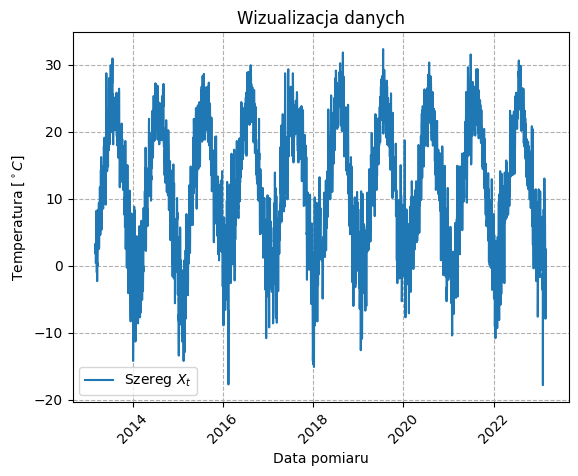

In [10]:
plt.plot(time, temp, label = 'Szereg $X_t$')
plt.grid(True, linestyle = '--')
plt.ylabel('Temperatura [$^\\circ C$]')
plt.xlabel('Data pomiaru')
plt.xticks(rotation = 45)
plt.legend()
plt.title("Wizualizacja danych")
plt.savefig('Temperature_data.png', bbox_inches='tight')
plt.show()

## 2. Przygotowanie danych do analizy

    2.1. Jakość danych

- zakres badanych wartości

In [11]:
# Nasz szereg X_t
Xt = temp.values

In [12]:
# minimalna i maksymalna prędkość wiatru
min_temp = np.min(Xt)
max_temp = np.max(Xt)

print('Minimalna prędkość wiatru w danych:', min_temp)
print('Maksymalna prędkość wiatru w danych:', max_temp)

Minimalna prędkość wiatru w danych: -17.8
Maksymalna prędkość wiatru w danych: 32.3


- Czy są wartości odstające?

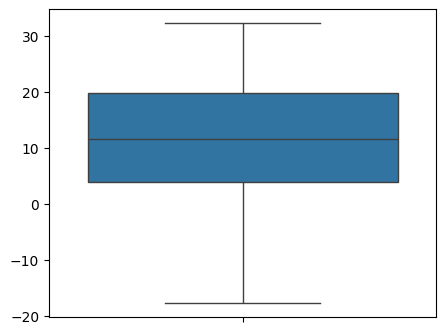

In [13]:
plt.figure(figsize=(5,4))
sns.boxplot(data=Xt)
plt.show()

    2.2. Dekompozycja szeregu czasowego

-  wykres ACF oraz PACF dla surowych danych - EMPIRYCZNIE

In [14]:
def autokowariancja_emp(x, h):
    n = len(x)
    autocov = np.zeros(len(h))
    for j, hi in enumerate(h):
        if hi < n:
            autocov[j] = (1 / n) * np.sum((x[:n - hi] - np.mean(x)) * (x[hi:] - np.mean(x)))
        else:
            autocov[j] = 0
    return autocov

In [15]:
def autokorelacja_emp(x, h):
    autocov = autokowariancja_emp(x, h)
    autocov_0 = autocov[0] 
    autokor = autocov / autocov_0
    return autokor

In [16]:
def partialautocor(x, h):
    gamma_hat = autokowariancja_emp(x, h)
    pacf = np.zeros(len(h))
    pacf[0] = 1.0 
    for k in range(1, len(h)):
        gamma_matrix = np.array([[gamma_hat[abs(i - j)] for j in range(k)] for i in range(k)])
        gamma_vector = gamma_hat[1 : k + 1]
        phi_k = np.linalg.solve(gamma_matrix, gamma_vector)
        pacf[k] = phi_k[-1]
    return pacf

In [17]:
h = 40
h_range = np.arange(h+1)
ACF_emp = autokorelacja_emp(x = Xt, h = h_range)
PACF_emp = partialautocor(x = Xt, h = h_range)

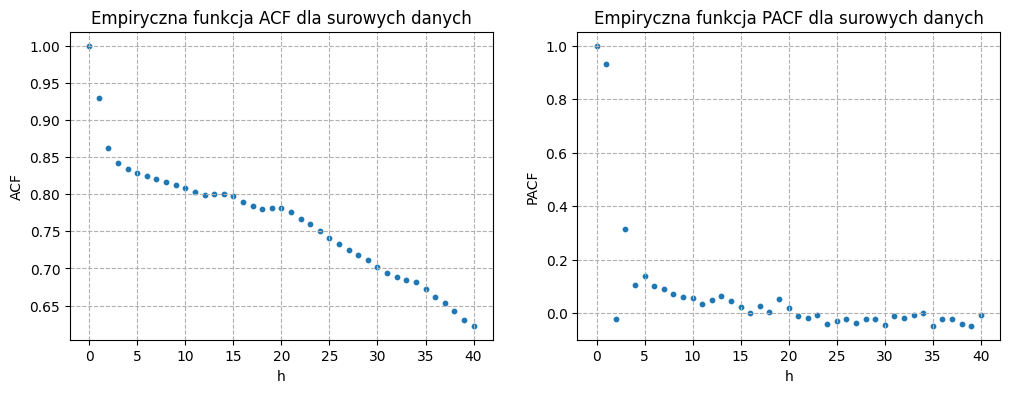

In [18]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.scatter(h_range, ACF_emp, s=10)
plt.grid(True, linestyle = '--')
plt.title('Empiryczna funkcja ACF dla surowych danych')
plt.xlabel('h')
plt.ylabel('ACF')

plt.subplot(1,2,2)
plt.scatter(h_range, PACF_emp, s=10)
plt.grid(True, linestyle = '--')
plt.title('Empiryczna funkcja PACF dla surowych danych')
plt.xlabel('h')
plt.ylabel('PACF')


plt.show()

-  wykres ACF oraz PACF dla surowych danych - WBUDOWANA FUNKCJA (statsmodels)

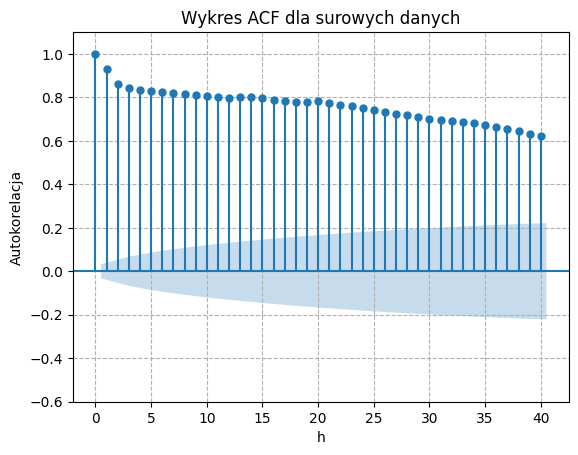

In [19]:
plot_acf(Xt, lags=h)
plt.title("Wykres ACF dla surowych danych")
plt.grid(True, linestyle='--')
plt.xlabel('h')
plt.ylabel('Autokorelacja')
plt.ylim(-0.6,1.1)

plt.savefig('ACF_raw_data.png', bbox_inches='tight')
plt.show()

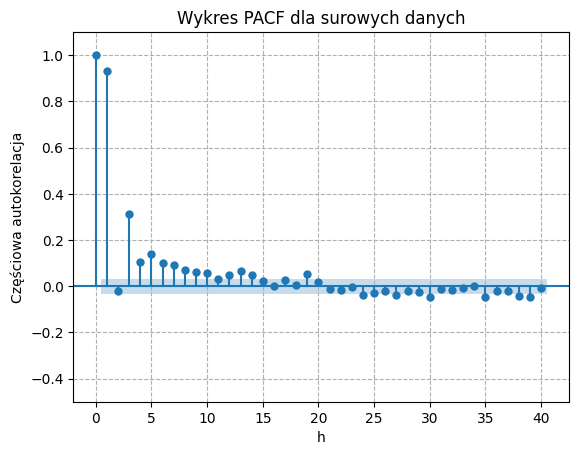

In [20]:
plot_pacf(Xt, lags=h, method='ywm')
plt.title("Wykres PACF dla surowych danych")
plt.grid(True, linestyle='--')
plt.xlabel('h')
plt.ylabel('Częściowa autokorelacja')
plt.ylim(-0.5,1.1)

plt.savefig('PACF_raw_data.png', bbox_inches='tight')
plt.show()


    2.3. (*opcjonalne) Testowanie stacjonarności - surowe dane

In [21]:
# Testowanie stacjonarności
def adfuller_test(series, sig=0.05):
    res = adfuller(series, autolag='AIC')    
    p_value = round(res[1], 3) 
    stats   = round(res[0], 3) 

    if p_value <= sig:
        print(f"Statystyka testowa = {stats}, p-Value = {p_value} => Stationary. ")
    else:
        print(f"Statystyka testowa = {stats}, p-value = {p_value} => Non-stationary.")

In [22]:
is_Xt_stationary = adfuller_test(Xt)
is_Xt_stationary

Statystyka testowa = -3.601, p-Value = 0.006 => Stationary. 


    2.4. Identyfikacja trendów deterministycznych

$$ X_t = m(t) + s(t) + Y(t)  $$

- trend m(t)

In [23]:
n = len(Xt)
t = np.linspace(0, n, n)
m_fit = np.polyfit(t, Xt, 1)
mt = np.polyval(m_fit, t)

In [24]:
Xt_without_trend = Xt - mt

- sezonowość s(t)

In [25]:
def s_func_para(t, a, b, c):
    return a*np.sin(b*t + c)

In [26]:
a_initial = (np.max(Xt) - np.min(Xt)) / 2
b_initial = 2 * np.pi / 365
c_initial = np.pi/2
d_initial = np.mean(Xt)

params, covariance = curve_fit(s_func_para, t, Xt_without_trend, p0=[a_initial, b_initial, c_initial])

a_fit, b_fit, c_fit = params
st = s_func_para(t, a_fit, b_fit, c_fit)

In [27]:
params

array([-12.19793189,   0.01720239,   2.13821696])

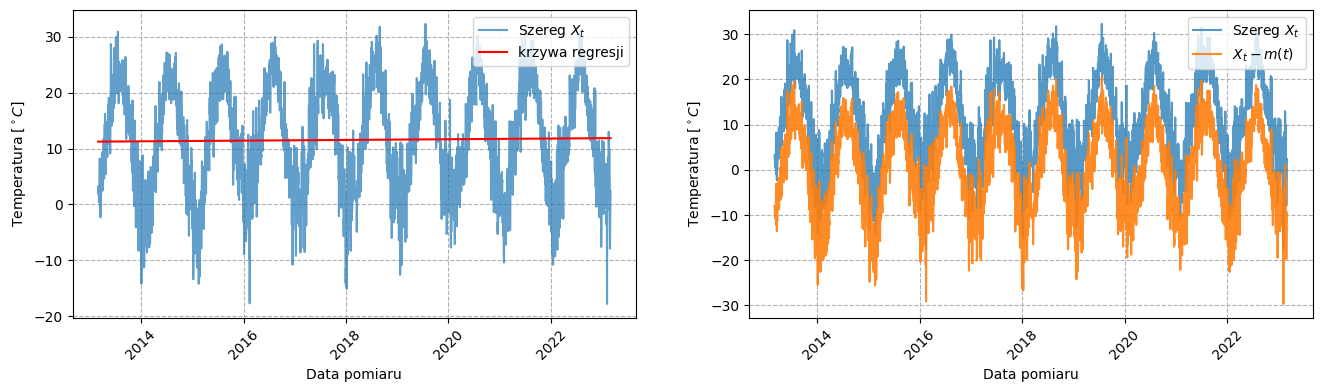

In [28]:
plt.figure(figsize=(16,4))

plt.subplot(1,2,1)
plt.plot(time, Xt, alpha = 0.7, label = 'Szereg $X_t$')
plt.plot(time, mt, color = 'red', label = 'krzywa regresji')
plt.xlabel('Data pomiaru')
plt.ylabel('Temperatura [$^\\circ C$]')
plt.xticks(rotation = 45)
plt.legend(loc = 'upper right')
plt.grid(True, linestyle='--')

plt.subplot(1,2,2)
plt.plot(time, Xt, alpha = 0.75, label = 'Szereg $X_t$')
plt.plot(time, Xt_without_trend, alpha = 0.9, label = '$X_t - m(t)$')
plt.xlabel('Data pomiaru')
plt.ylabel('Temperatura [$^\\circ C$]')
plt.xticks(rotation = 45)
plt.legend(loc = 'upper right')
plt.grid(True, linestyle='--')

plt.savefig('Xt_without_trend.png', bbox_inches='tight')
plt.show()

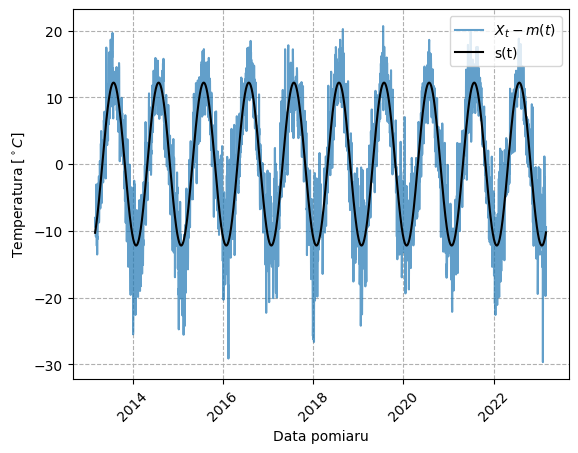

In [29]:
plt.plot(time, Xt_without_trend, alpha = 0.7, label = '$X_t - m(t) $')
plt.plot(time, st, color = 'black', label = 's(t)')
plt.xlabel('Data pomiaru')
plt.ylabel('Temperatura [$^\\circ C$]')
plt.xticks(rotation = 45)
plt.legend(loc = 'upper right')
plt.grid(True, linestyle='--')

plt.savefig('Xt_seasonal.png', bbox_inches='tight')
plt.show()

- Szereg czasowy liniowy $Y_t$

In [30]:
Yt = Xt - mt - st

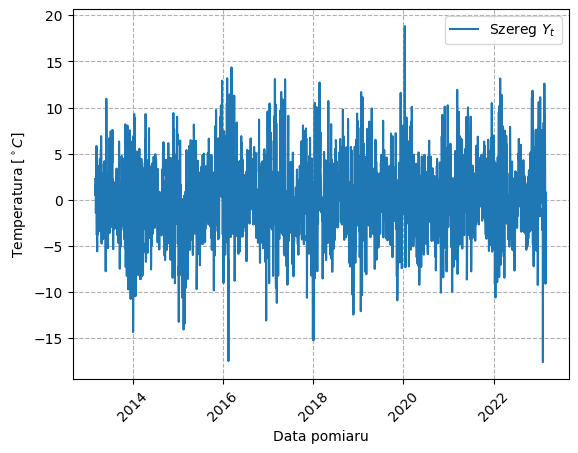

In [31]:
plt.plot(time, Yt, label = 'Szereg $Y_t$')
plt.grid(True, linestyle='--')
plt.xlabel('Data pomiaru')
plt.ylabel('Temperatura [$^\\circ C$]')
plt.xticks(rotation = 45)
plt.legend()

plt.savefig('cleanYt.png', bbox_inches='tight')
plt.show()

    2.5. Wykres ACF oraz PACF dla uzyskanego szeregu

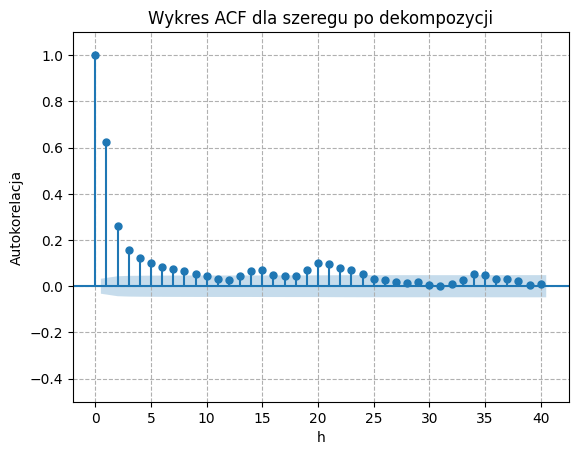

In [32]:
plot_acf(Yt, lags=h)
plt.title("Wykres ACF dla szeregu po dekompozycji")
plt.grid(True, linestyle='--')
plt.xlabel('h')
plt.ylabel('Autokorelacja')
plt.ylim(-0.5,1.1)

plt.savefig('ACF_data.png', bbox_inches='tight')
plt.show()

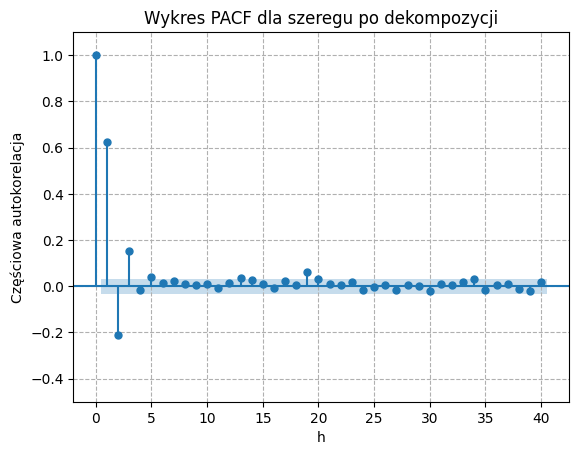

In [33]:
#zmiana: w plot_pacf podany był szereg Xt (sprzed dekompozycji)
plot_pacf(Yt, lags=h, method='ywm')
plt.title("Wykres PACF dla szeregu po dekompozycji")
plt.grid(True, linestyle='--')
plt.xlabel('h')
plt.ylabel('Częściowa autokorelacja')
plt.ylim(-0.5,1.1)

plt.savefig('PACF_data.png', bbox_inches='tight')
plt.show()


    2.6. (*opcjonalne) Testowanie stacjonarności - po dekompozycji

In [34]:
is_Yt_stationary = adfuller_test(Yt)
is_Yt_stationary

Statystyka testowa = -10.159, p-Value = 0.0 => Stationary. 


## 3. Modelowanie danych przy pomocy ARMA

    3.1. Dobranie rzędu modelu (kryteria informacyjne)

In [35]:
p_values = []
q_values = []
BIC = []
AIC = []
HQIC = []
df = pd.DataFrame()

max_p = 4
max_q = 4

for p in range(0, max_p):
    for q in range(0, max_q):
        
        arima_model = ARIMA(Yt, order=(p, 0, q))
        arima_model_fit = arima_model.fit()
        
        p_values.append(p)
        q_values.append(q)
        AIC.append(arima_model_fit.aic)
        BIC.append(arima_model_fit.bic)
        HQIC.append(arima_model_fit.hqic)

df['p'] = p_values
df['q'] = q_values
df['AIC'] = AIC
df['BIC'] = BIC
df['HQIC'] = HQIC


In [36]:
#posortowanie wartości wg wartości AIC (od najmniejszej)
df.sort_values(by='AIC').head()

,p,q,AIC,BIC,HQIC
10,2,2,18637.794062,18675.013886,18651.048506
11,2,3,18639.793912,18683.217040,18655.257430
14,3,2,18639.793949,18683.217077,18655.257467
15,3,3,18641.539307,18691.165740,18659.211899
7,1,3,18642.573640,18679.793464,18655.828084


In [37]:
#posortowanie wartości wg wartości BIC (od najmniejszej)
df.sort_values(by='BIC').head()

,p,q,AIC,BIC,HQIC
10,2,2,18637.794062,18675.013886,18651.048506
7,1,3,18642.573640,18679.793464,18655.828084
12,3,0,18650.986950,18682.003470,18662.032320
11,2,3,18639.793912,18683.217040,18655.257430
14,3,2,18639.793949,18683.217077,18655.257467


In [38]:
#posortowanie wartości wg wartości HQIC (od najmniejszej)
df.sort_values(by='HQIC').head()

,p,q,AIC,BIC,HQIC
10,2,2,18637.794062,18675.013886,18651.048506
11,2,3,18639.793912,18683.217040,18655.257430
14,3,2,18639.793949,18683.217077,18655.257467
7,1,3,18642.573640,18679.793464,18655.828084
15,3,3,18641.539307,18691.165740,18659.211899


    3.2. Estymacja parametrów modelu wybraną metodą.

In [40]:
#estymacja współczynników phi modelu AR(p) metodą Yule-Walkera

def yule_walker_estimation(data, p):
    data_centered = data - np.mean(data)
    autocovariance = acovf(data_centered, fft=True)[:p+1]
    Gamma = np.array([[autocovariance[abs(i - j)] for j in range(p)] for i in range(p)])
    acovf_array = autocovariance[1:p+1]
    phi_vector = np.linalg.solve(Gamma, acovf_array)
    
    return phi_vector

In [41]:
phi_1, phi_2 = yule_walker_estimation(Yt, p)
print("Współczynnik phi_1 = ", phi_1, ", współczynnik phi_2 = ", phi_2)

Współczynnik phi_1 =  0.7559664120339143 , współczynnik phi_2 =  -0.21043588585930614


In [71]:
#inne sposoby wyznaczania parametrów
p = 2
q = 2

statespace_model = ARIMA(Yt, order=(p, 0, q)).fit(method='statespace')
statespace_model.params[1:-1]

array([ 1.25330217, -0.28790965, -0.46537367, -0.414144  ])

In [72]:
innovations_mle_model = ARIMA(Yt, order=(p, 0, q)).fit(method='innovations_mle')
innovations_mle_model.params[1:-1]

array([ 1.25331252, -0.28792941, -0.46538349, -0.41412908])

In [79]:
hannan_rissanen_model= ARIMA(Yt, order=(p, 0, q)).fit(method='hannan_rissanen')
hannan_rissanen_model.params[1:-1]

array([ 1.08493636, -0.22386188, -0.29518272, -0.34362018])

In [83]:
parameter_frame = pd.DataFrame()
parameter_frame["parametry"] = ["phi_1", "phi_2", "theta_1", "theta_2"]
parameter_frame["statespace"] = statespace_model.params[1:-1]
parameter_frame["innovations_mle"] = innovations_mle_model.params[1:-1]
parameter_frame["hannan_rissanen"] = hannan_rissanen_model.params[1:-1]

parameter_frame


,parametry,statespace,innovations_mle,hannan_rissanen
0,phi_1,1.253302,1.253313,1.084936
1,phi_2,-0.287910,-0.287929,-0.223862
2,theta_1,-0.465374,-0.465383,-0.295183
3,theta_2,-0.414144,-0.414129,-0.343620


##  4. Ocena dopasowania modelu

    4.1. Przedziały ufności dla PACF/ACF

    4.2. Porównanie linii kwantylowych z trajektorią

## 5. Weryfikacja założeń dotyczących szumu

    5.1. Założenie dot. średniej (wykres wartości resztowych / t test)

a) wykres wartości resztowych

In [44]:
# residua
residuals = fitted_model.resid
fitted_model.params[1:-1]


array([ 1.25331252, -0.28792941, -0.46538349, -0.41412908])

In [45]:
np.max(residuals)

12.091312179518956

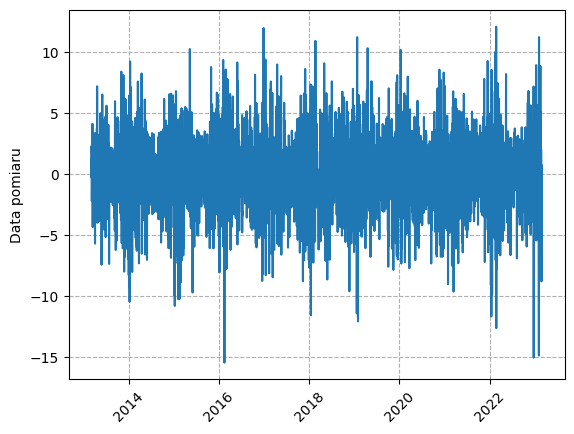

In [46]:
plt.plot(time, residuals)
plt.grid(True, linestyle='--')
plt.xticks(rotation = 45)
plt.ylabel('Data pomiaru')

plt.savefig('residua.png', bbox_inches='tight')
plt.show()

b) t test

$H_0: \bar{x} = 0$

$H_1: \bar{x} \neq 0$

In [47]:
def t_test(Xt, mean_value, confidence_level):
    t_stat, p_value = ttest_1samp(Xt, mean_value)
    if p_value < 1 - confidence_level:
        print(f"Statystyka testowa = {t_stat}, p-Value = {p_value} < {1- confidence_level} => Odrzucono hipotezę zerową.")
    else:
        print(f"Statystyka testowa = {t_stat}, p-Value = {p_value} >= {1- confidence_level} => Nie można odrzucić hipotezy zerowej.")

In [48]:
t_test(residuals , mean_value = 0, confidence_level = 0.95)

Statystyka testowa = -0.012047407391173779, p-Value = 0.9903884502157669 >= 0.050000000000000044 => Nie można odrzucić hipotezy zerowej.


In [49]:
mu_residuals = np.mean(residuals)
mu_residuals

-0.0006173716876235661

    5.2. Założenie dot. wariancji (wykres wartości resztowych / Modified Levene Test / Arch Test)

a) wykres wartości resztowych

b) Test Levene’a jednorodności wariancji

$H_0:$ Wszystkie grupy mają tą samą wariancję

$H_1:$ Wariancje są heterogeniczne (niejednorodne)

In [50]:
def levene_test(X, confidence_level):
    n = len(Xt)
    group1 = Xt[:n//3]
    group2 = Xt[n//3:2*n//3]
    group3 = Xt[2*n//3:]

    levene_stat, p_value = levene(group1, group2, group3)
    
    if p_value < 1-confidence_level:
        print(f"Statystyka testowa = {levene_stat}, p-Value = {p_value} < {1- confidence_level} => Odrzucono hipotezę zerową.")
    else:
        print(f"Statystyka testowa = {levene_stat}, p-Value = {p_value} >= {1- confidence_level} => Nie można odrzucić hipotezy zerowej.")

In [51]:
np.var(residuals[:n//3])

9.422424562969205

In [52]:
np.var(residuals[n//3:2*n//3])

9.517274540613414

In [53]:
np.var(residuals[2*n//3:])

9.805126478328134

In [54]:
levene_test(residuals, confidence_level=0.95)

Statystyka testowa = 1.8473316413696923, p-Value = 0.15780466574326127 >= 0.050000000000000044 => Nie można odrzucić hipotezy zerowej.


In [55]:
var_residuals = np.var(residuals)
var_residuals

9.590406020181938

c) Test ARCH

In [56]:
def arch_test(Xt, confidence_level):
    arch_stat, p_value, _, _ = het_arch(Xt)
    if p_value < 1-confidence_level:
        print(f"Statystyka testowa = {arch_stat}, p-Value = {p_value} < {1- confidence_level} => Odrzucono hipotezę zerową.")
    else:
        print(f"Statystyka testowa = {arch_stat}, p-Value = {p_value} >= {1- confidence_level} => Nie można odrzucić hipotezy zerowej.")

In [57]:
arch_test(residuals, confidence_level=0.95)

Statystyka testowa = 149.7460838908015, p-Value = 4.2038795090766805e-27 < 0.050000000000000044 => Odrzucono hipotezę zerową.


    5.3. Założenie dot. niezależności (wykres ACF/PACF dla wartości resztowych / test Ljunga-Boxa)

a) Wykres ACF/PACF dla wartości resztowych

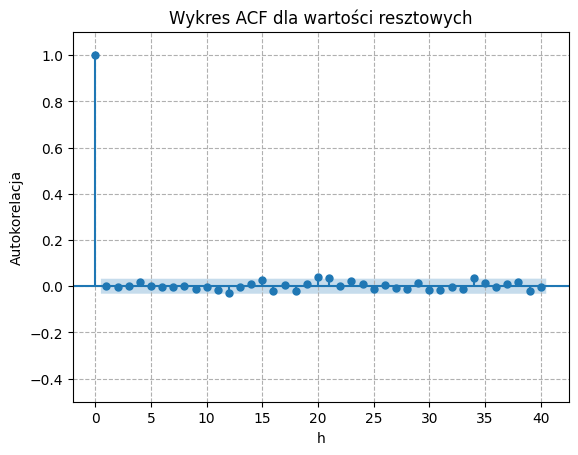

In [58]:
plot_acf(residuals, lags=h)
plt.title("Wykres ACF dla wartości resztowych")
plt.grid(True, linestyle='--')
plt.xlabel('h')
plt.ylabel('Autokorelacja')
plt.ylim(-0.5,1.1)

plt.savefig('ACF_residua.png', bbox_inches='tight')
plt.show()

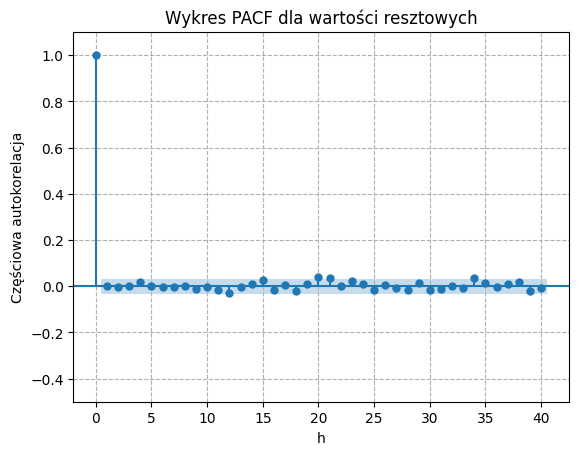

In [59]:
plot_pacf(residuals, lags=h, method='ywm')
plt.title("Wykres PACF dla wartości resztowych")
plt.grid(True, linestyle='--')
plt.xlabel('h')
plt.ylabel('Częściowa autokorelacja')
plt.ylim(-0.5,1.1)

plt.savefig('PACF_residua.png', bbox_inches='tight')
plt.show()

b) Test Ljunga-Boxa

$H_0:$ dane są nieskorelowane

$H_1:$ dane są skorelowane

In [60]:
def LB_test(Xt, confidence_level):
    LB_result = acorr_ljungbox(Xt, lags=[10], return_df=True)  #
    LB_stat = LB_result['lb_stat'].iloc[0]
    p_value = LB_result['lb_pvalue'].iloc[0]

    if p_value < 1 - confidence_level:
        print(f"Statystyka testowa = {LB_stat:.4f}, p-Value = {p_value:.4f} < {1 - confidence_level} => Odrzucono hipotezę zerową.")
    else:
        print(f"Statystyka testowa = {LB_stat:.4f}, p-Value = {p_value:.4f} >= {1 - confidence_level} => Nie można odrzucić hipotezy zerowej.")

In [61]:
LB_test(residuals, confidence_level=  0.95)

Statystyka testowa = 1.7926, p-Value = 0.9977 >= 0.050000000000000044 => Nie można odrzucić hipotezy zerowej.


    5.4. Założenie dot. normalności rozkładu (dystrybuanta / gęstość / wykres kwantylowy / testy na normalność)

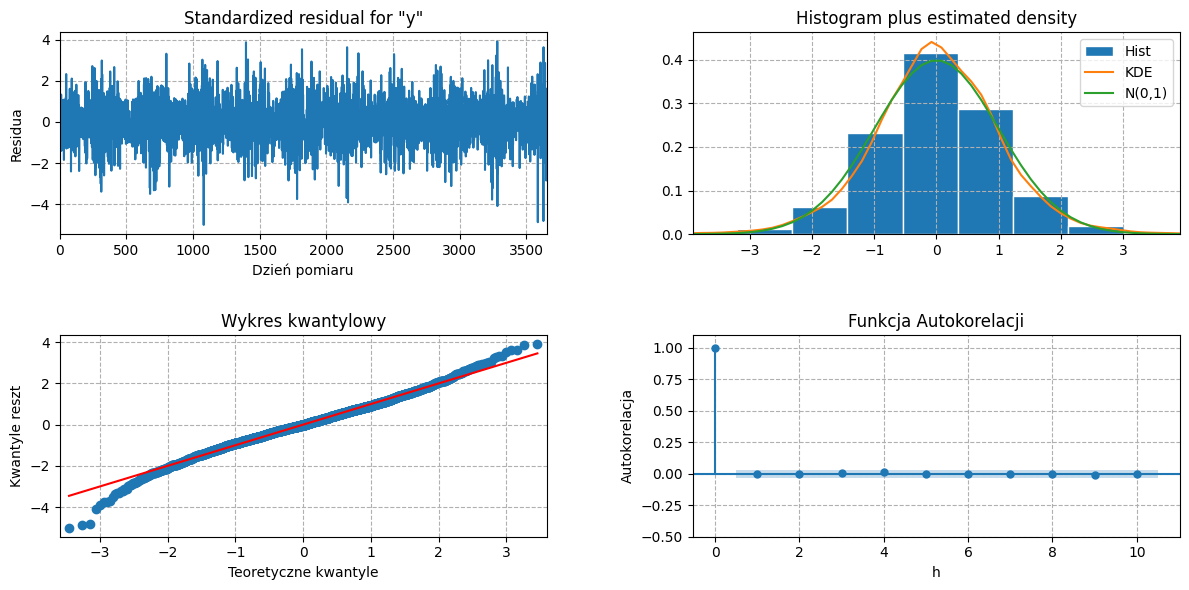

In [62]:
fig = fitted_model.plot_diagnostics(0, figsize=(12, 6))
axes = fig.get_axes()
for ax in axes:
    ax.grid(True, linestyle='--')

#wykres 1
axes[0].set_ylabel('Residua')
axes[0].set_xlabel('Dzień pomiaru')

#wykres 2

#wykres 3
axes[2].set_ylabel('Kwantyle reszt')
axes[2].set_xlabel('Teoretyczne kwantyle')
axes[2].set_title('Wykres kwantylowy')

#wykres 4
axes[3].set_ylim(-0.5, 1.1)
axes[3].set_ylabel('Autokorelacja')
axes[3].set_xlabel('h')
axes[3].set_title('Funkcja Autokorelacji')


plt.tight_layout()
fig.subplots_adjust(hspace=0.5, wspace=0.3)
plt.show()


In [63]:
xs = np.linspace(np.min(residuals), np.max(residuals), 1000)
f_normal = norm.pdf(xs, mu_residuals, np.sqrt(var_residuals))
F_normal = norm.cdf(xs, mu_residuals, np.sqrt(var_residuals))

- dystrybuanta

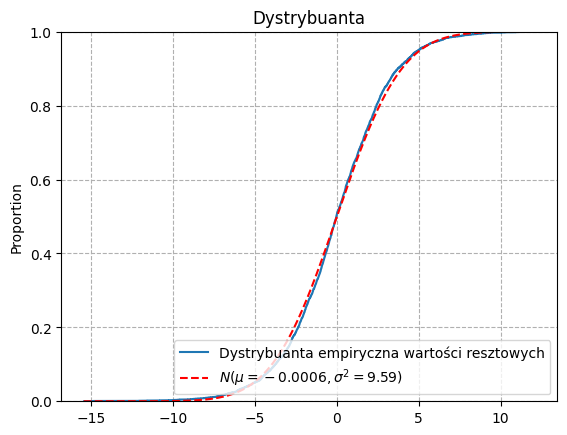

In [64]:
sns.ecdfplot(residuals, label = "Dystrybuanta empiryczna wartości resztowych")
plt.plot(xs, F_normal, 'r--', label = f'$N(\\mu = {mu_residuals:.4f}, \\sigma^2 = {var_residuals:.2f})$')
plt.grid(True, linestyle='--')
plt.legend(loc='lower right')
plt.title('Dystrybuanta')

plt.savefig('F_residua.png', bbox_inches='tight')
plt.show()

- gęstość

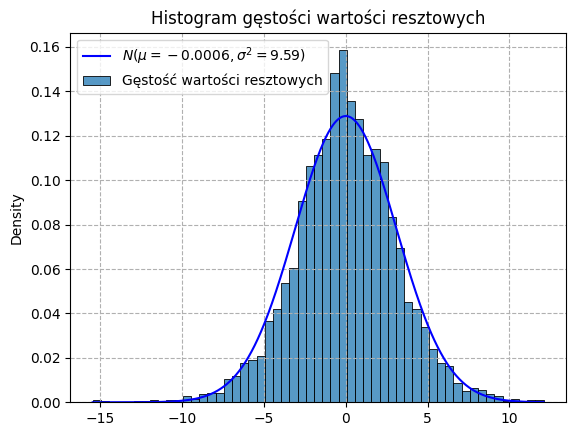

In [65]:
sns.histplot(residuals, stat="density", label = 'Gęstość wartości resztowych')
plt.plot(xs, f_normal, 'b', label = f'$N(\\mu = {mu_residuals:.4f}, \\sigma^2 = {var_residuals:.2f})$')
plt.title("Histogram gęstości wartości resztowych")
plt.grid(True, linestyle='--')
plt.legend()

plt.savefig('density_residua.png', bbox_inches='tight')
plt.show()

- Wykres kwantylowy

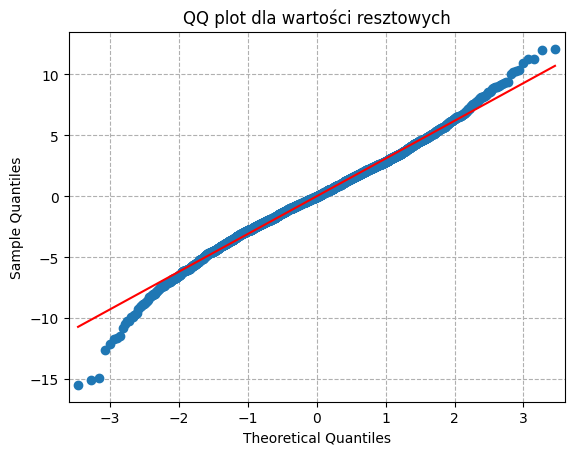

In [66]:
# QQ plot
sm.qqplot(residuals, line="s")
plt.title("QQ plot dla wartości resztowych")
plt.grid(True, linestyle = '--')

plt.savefig('QQ_residua.png', bbox_inches='tight')
plt.show()

- Testy na normalność

a) Test Shapiro-Wilka

$H_0$: Próba pochodzi z populacji o rozkładzie normalnym

$H_1$: Próba nie pochodzi z populacji o rozkładzie normalnym

In [67]:
def shapiro_test(Xt, confidence_level):
    shapiro_stat, p_value = shapiro(Xt)

    if p_value < 1 - confidence_level:
        print(f"Statystyka testowa = {shapiro_stat:.4f}, p-Value = {p_value:.4f} < {1 - confidence_level} => Odrzucono hipotezę zerową.")
    else:
        print(f"Statystyka testowa = {shapiro_stat:.4f}, p-Value = {p_value:.4f} >= {1 - confidence_level} => Nie można odrzucić hipotezy zerowej.")

In [68]:
shapiro_test(residuals, confidence_level=0.95)

Statystyka testowa = 0.9922, p-Value = 0.0000 < 0.050000000000000044 => Odrzucono hipotezę zerową.


b) Test Jarque-Bera - oparty na miarach skośności i kurtozy rozkładu badanej zmiennej. 

$H_0$: normalność badanego rozkładu

$H_1$: brak normalności badanego rozkładu

In [69]:
def JB_test(Xt, confidence_level):
    JB_stat, p_value = jarque_bera(Xt)

    if p_value < 1 - confidence_level:
        print(f"Statystyka testowa = {JB_stat:.4f}, p-Value = {p_value:.4f} < {1 - confidence_level} => Odrzucono hipotezę zerową.")
    else:
        print(f"Statystyka testowa = {JB_stat:.4f}, p-Value = {p_value:.4f} >= {1 - confidence_level} => Nie można odrzucić hipotezy zerowej.")

In [70]:
JB_test(residuals, confidence_level=0.95)

Statystyka testowa = 191.6388, p-Value = 0.0000 < 0.050000000000000044 => Odrzucono hipotezę zerową.


## 6. Podsumowanie